In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path('data')

# Preparing the Data for Training

## Reading the Data

In [3]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
demographics = pd.read_csv(DATADIR / 'df_demographics.csv')
locations = pd.read_csv(DATADIR / 'df_location_ratio.csv')

## Cleaning a bit More

In [4]:
phq9 = phq9.iloc[:, 1:]
phq9.rename(columns={'phq9Date': 'date'}, inplace=True)
demographics = demographics.iloc[:, 1:]

phq9

,participant_id,week,sum_phq9,date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,EN00155,5,10,2016-09-30,2,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,10.0,2,0.0,4.0
4787,ES00027,9,21,2016-12-11,3,1.0,3.0,3.0,3.0,2.0,2.0,3.0,1.0,21.0,5,0.0,0.0
4788,EN00554,3,14,2016-11-28,2,2.0,3.0,3.0,1.0,1.0,2.0,0.0,0.0,14.0,3,0.0,2.0
4789,EN00225,3,3,2016-09-21,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1,0.0,0.0


## Joining the Tables

In [5]:
from data_processing import *
import data_processing as dp

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


TYPE = 'classification' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
locations = load_locations(DATADIR / 'df_location_ratio.csv')
demographics = load_demographics(DATADIR / 'df_demographics.csv')

In [6]:
phq9

,participant_id,date,target
0,BLUE-00048,2014-08-08,1
1,BLUE-00050,2014-08-23,2
2,BLUE-00050,2014-08-30,1
3,BLUE-00050,2014-09-08,1
4,BLUE-00050,2014-09-22,1
...,...,...,...
4786,EN00155,2016-09-30,2
4787,ES00027,2016-12-11,5
4788,EN00554,2016-11-28,3
4789,EN00225,2016-09-21,1


In [7]:
locations

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,EN00033,2016-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,EN00033,2016-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,EN00033,2016-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,EN00033,2016-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278472
4,EN00033,2016-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341,ES05073,2017-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11342,ES05073,2017-03-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11343,ES05073,2017-03-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11344,ES05073,2017-03-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [8]:
demographics

,participant_id,working,income_satisfaction,income_lastyear,age,gen_Female,gen_Male,martial_Married/Partner,martial_Separated/Widowed/Divorced,martial_Single,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00033,1.0,3.0,6.0,52.0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,EN00034,1.0,3.0,4.0,32.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,0.0,2.0,2.0,57.0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,EN00036,1.0,3.0,3.0,55.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,EN00037,0.0,2.0,6.0,34.0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,ES05078,0.0,2.0,4.0,38.0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1064,ES05079,0.0,2.0,1.0,31.0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1065,ES05080,1.0,1.0,1.0,32.0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1066,ES05081,0.0,1.0,1.0,33.0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
from data_processing import *
import data_processing as dp

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


TYPE = 'classification' # regression|classification
TARGET = 'value' # diff|value
SEED = 433
    
def train(type=TYPE, target=TARGET, seed=SEED, feature_selection=False):
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=type, target=target)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')

    combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)

    x, y = dp.xy_split(combined)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=seed)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    print()

    if type == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=seed)
        model.fit(x_train, y_train)
        
        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')
        
        train_acc = 100 * model.score(x_train, y_train)
        test_acc = 100 * model.score(x_test, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%')
        print(f'Test set accuracy:  {test_acc:.2f}%')

    elif type == 'classification':
        model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
        model.fit(x_train, y_train)
        
        train_acc = 100 * model.score(x_train, y_train)
        test_acc = 100 * model.score(x_test, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%') 
        print(f'Test set accuracy:  {test_acc:.2f}%')

    if feature_selection == True:
        print()
        print('-'*25)
        print("After feature selection:")
        sfm = SelectFromModel(model, threshold=0.01, prefit=True)
        x_train_new = sfm.transform(x_train)
        x_test_new = sfm.transform(x_test)
        print('Train set shape:', x_train_new.shape)
        print('Test set shape:', x_test_new.shape)
        print()
        sfm.estimator.fit(x_train_new, y_train)
        train_acc = 100 * sfm.estimator.score(x_train_new, y_train)
        test_acc = 100 * sfm.estimator.score(x_test_new, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%') 
        print(f'Test set accuracy:  {test_acc:.2f}%')

In [15]:
# Also, maybe use the std. instead of just the mean for features
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home

In [29]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
locations = load_locations(DATADIR / 'df_location_ratio.csv')
demographics = load_demographics(DATADIR / 'df_demographics.csv')

combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined = dp.rf_preprocess(combined)

x, y = dp.xy_split(combined)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)

model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=SEED)
model.fit(x_train, y_train)

train_acc = 100 * model.score(x_train, y_train)
test_acc = 100 * model.score(x_test, y_test)
print(f'Train set accuracy: {train_acc:.2f}%') 
print(f'Test set accuracy:  {test_acc:.2f}%')

/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_rows.fillna(0.0, inplace=True)
/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_rows.fillna(0.0, inplace=True)
/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid

AttributeError: 'DataFrame' object has no attribute 'has_phq9'

In [12]:
combined_1 = combined.drop(combined.columns.intersection(['target', 'participant_id', 'date']), axis=1)
combined_1

,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,home,home_store,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,0.0,0.0,0.000801,0.0,0.0,0.0,0.0,0.0,0.450850,0.0,...,0,1,0,0,0,1,0,0,0,0
1157,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.541909,0.0,...,0,1,0,0,0,1,0,0,0,0
1158,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.409618,0.0,...,0,1,0,0,0,1,0,0,0,0
1159,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.552518,0.0,...,0,1,0,0,0,1,0,0,0,0


# Feature selection

## Feature importances

In [13]:
# The feature importance is a measure of how much each feature contributes to the prediction
feature_importances = pd.DataFrame({'feature': combined_1.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,home,0.225915
1,age,0.141435
2,income_lastyear,0.073659
3,work,0.057083
4,income_satisfaction,0.051609
5,working,0.032990
6,health,0.031701
7,edu_University,0.026554
8,race_Non-Hispanic White,0.024870
9,martial_Married/Partner,0.023001


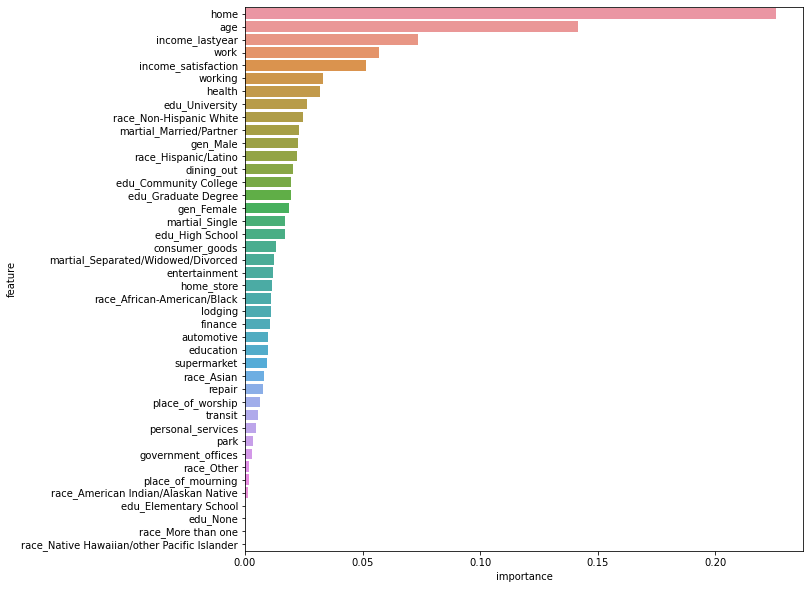

In [14]:
# Pie chart of feature importances, seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Feature selection

In [31]:
train(type=TYPE, target=TARGET, feature_selection=True)

/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  f = df.groupby(inds).agg(m)
/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  f = df.groupby(inds).agg(m)
/home/julien/Documents/ml-project-2-nocommonpoint_v2/data_processing.py:122: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

AttributeError: 'DataFrame' object has no attribute 'has_phq9'

In [16]:
train(type='classification', target='diff', feature_selection=True)

Train set shape: (748, 42)
Test set shape: (132, 42)

Train set accuracy: 93.18%
Test set accuracy:  43.94%

-------------------------
After feature selection:
Train set shape: (748, 30)
Test set shape: (132, 30)

Train set accuracy: 93.32%
Test set accuracy:  42.42%


In [17]:
train(type='regression', target='value', feature_selection=True)

Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 1.9420
Test set RMSE:  4.2006
Train set accuracy: 90.33%
Test set accuracy:  48.02%

-------------------------
After feature selection:
Train set shape: (986, 18)
Test set shape: (175, 18)

Train set accuracy: 90.32%
Test set accuracy:  49.39%


In [18]:
train(type='regression', target='diff', feature_selection=True)

Train set shape: (748, 42)
Test set shape: (132, 42)

Train set RMSE: 2.7023
Test set RMSE:  6.0732
Train set accuracy: 67.57%
Test set accuracy:  -26.93%

-------------------------
After feature selection:
Train set shape: (748, 33)
Test set shape: (132, 33)

Train set accuracy: 67.27%
Test set accuracy:  -27.40%


# Tests

In [28]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
locations = load_locations(DATADIR / 'df_location_ratio.csv')
demographics = load_demographics(DATADIR / 'df_demographics.csv')
combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined = dp.rf_preprocess(combined)

In [22]:
dailies = [('locations', locations)]
constants = [demographics]

# How does this work?
# Basically, "combine" daily data between multiple phq9 points.
# example:
# phq9  daily0  daily1
# 3.00  718     333
# NaN   333     444
# NaN   555     666
# 4.00  NaN     NaN 
# becomes (with mean reduction):
# phq9  daily0  daily1
# 3.00  718     333
# 4.00  444     555

# Remember that PHQ9 is also daily.
# Dailies should be (name, csv) pairs.

# Also, let's add an extra column has_* to check for daily attributes later
has_keys = ['has_phq9']
phq9['has_phq9'] = True

for name, csv in dailies:
    k = f'has_{name}'
    csv[k] = True
    has_keys.append(k)

In [23]:
has_keys

['has_phq9', 'has_locations']

In [24]:
# Now, merge everything. Use an 'outer' merge so that all entries are included,
# and those who don't exist for that date get NaNs
daily_merged = phq9
for name, csv in dailies:
    daily_merged = daily_merged.merge(csv, on=['participant_id', 'date'], how='outer')
daily_merged.sort_values(by=['participant_id', 'date'], inplace=True)

# To make things look a bit cleaner, replace NaN with False for has_* columns
for has_key in has_keys:
    daily_merged[has_key].fillna(False, inplace=True)
daily_merged

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work,has_locations
0,BLUE-00048,2014-08-08,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,BLUE-00050,2014-08-23,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,BLUE-00050,2014-08-30,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,BLUE-00050,2014-09-08,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,BLUE-00050,2014-09-22,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,2014-12-31,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3623,YELLOW-00263,2014-12-17,3.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3624,YELLOW-00263,2014-12-24,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3625,YELLOW-00263,2014-12-31,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [25]:
def _group_and_reduce_phq9(df, method='mean'):
    inds = _group_by_phq9(df)
    df = df.groupby(inds).agg(method, numeric_only=True)
    return df

def _group_by_phq9(df):
    # Assign a different group number to each consecutive phq9 'block'
    c = 0
    groups = []
    # Probably can derive this from some kind of cumsum, but brain is offline atm
    for k in df.has_phq9:
        groups.append(c)
        if k:
            c += 1
    return groups


In [26]:
target_columns = [c for c in daily_merged.columns if c.startswith('has_')]
target_columns.extend(['target'])
non_agg_columns = daily_merged[target_columns]
agg_columns = daily_merged.drop(target_columns, axis=1)

non_agg_columns


,has_phq9,has_locations,target
0,True,False,1.0
1,True,False,2.0
2,True,False,1.0
3,True,False,1.0
4,True,False,1.0
...,...,...,...
3622,True,False,2.0
3623,True,False,3.0
3624,True,False,2.0
3625,True,False,2.0


In [27]:
agg_columns

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,BLUE-00048,2014-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BLUE-00050,2014-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BLUE-00050,2014-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BLUE-00050,2014-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLUE-00050,2014-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3623,YELLOW-00263,2014-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3624,YELLOW-00263,2014-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3625,YELLOW-00263,2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
pgrp = daily_merged.groupby('participant_id')
inds = pgrp.apply(_group_by_phq9)
inds

participant_id
BLUE-00048                           [0]
BLUE-00050         [0, 1, 2, 3, 4, 5, 6]
BLUE-00051      [0, 1, 2, 3, 4, 5, 6, 7]
BLUE-00052      [0, 1, 2, 3, 4, 5, 6, 7]
BLUE-00053      [0, 1, 2, 3, 4, 5, 6, 7]
                          ...           
YELLOW-00259                [0, 1, 2, 3]
YELLOW-00260    [0, 1, 2, 3, 4, 5, 6, 7]
YELLOW-00261                         [0]
YELLOW-00262                   [0, 1, 2]
YELLOW-00263                [0, 1, 2, 3]
Length: 970, dtype: object

In [35]:
# Now we need to do the reduction. Now, I'm sure there is some sort of
# .groupby() magic that can handle this, but I'll do it the lazy way for now.
pgrp = daily_merged.groupby('participant_id')
daily_rows = pgrp.apply(_group_and_reduce_phq9)
daily_rows

target  has_phq9  automotive  consumer_goods  dining_out  \
participant_id                                                               
BLUE-00048     0     1.0       1.0         NaN             NaN         NaN   
BLUE-00050     0     2.0       1.0         NaN             NaN         NaN   
               1     1.0       1.0         NaN             NaN         NaN   
               2     1.0       1.0         NaN             NaN         NaN   
               3     1.0       1.0         NaN             NaN         NaN   
...                  ...       ...         ...             ...         ...   
YELLOW-00262   2     2.0       1.0         NaN             NaN         NaN   
YELLOW-00263   0     3.0       1.0         NaN             NaN         NaN   
               1     2.0       1.0         NaN             NaN         NaN   
               2     2.0       1.0         NaN             NaN         NaN   
               3     2.0       1.0         NaN             NaN         NaN   

                  education  entertainment  finance  government_offices  \
participant_id                                                            
BLUE-00048     0        NaN            NaN      NaN                 NaN   
BLUE-00050     0        NaN            NaN      NaN                 NaN   
               1        NaN            NaN      NaN                 NaN   
               2        NaN            NaN      NaN                 NaN   
               3        NaN            NaN      NaN                 NaN   
...                     ...            ...      ...                 ...   
YELLOW-00262   2        NaN            NaN      NaN                 NaN   
YELLOW-00263   0        NaN            NaN      NaN                 NaN   
               1        NaN            NaN      NaN                 NaN   
               2        NaN            NaN      NaN                 NaN   
               3        NaN            NaN      NaN                 NaN   

                  health  ...  lodging  park  personal_services  \
participant_id            ...                                     
BLUE-00048     0     NaN  ...      NaN   NaN                NaN   
BLUE-00050     0     NaN  ...      NaN   NaN                NaN   
               1     NaN  ...      NaN   NaN                NaN   
               2     NaN  ...      NaN   NaN                NaN   
               3     NaN  ...      NaN   NaN                NaN   
...                  ...  ...      ...   ...                ...   
YELLOW-00262   2     NaN  ...      NaN   NaN                NaN   
YELLOW-00263   0     NaN  ...      NaN   NaN                NaN   
               1     NaN  ...      NaN   NaN                NaN   
               2     NaN  ...      NaN   NaN                NaN   
               3     NaN  ...      NaN   NaN                NaN   

                  place_of_mourning  place_of_worship  repair  supermarket  \
participant_id                                                               
BLUE-00048     0                NaN               NaN     NaN          NaN   
BLUE-00050     0                NaN               NaN     NaN          NaN   
               1                NaN               NaN     NaN          NaN   
               2                NaN               NaN     NaN          NaN   
               3                NaN               NaN     NaN          NaN   
...                             ...               ...     ...          ...   
YELLOW-00262   2                NaN               NaN     NaN          NaN   
YELLOW-00263   0                NaN               NaN     NaN          NaN   
               1                NaN               NaN     NaN          NaN   
               2                NaN               NaN     NaN          NaN   
               3                NaN               NaN     NaN          NaN   

                  transit  work  has_locations  
participant_id                                  
BLUE-00048     0      NaN   NaN           

# Group features

In [38]:
locations = load_locations(DATADIR / 'df_location_ratio.csv')
locations = locations.iloc[:, 2:]
locations

,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,home,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278472
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# merge columns 'consumer_goods', 'home_store', 'supermarket' of locations into one column "store"


# Merge columns 0, 1, 2 into new column



In [ ]:
# automotive, repair

# place of mourning, place of worship

# finance, government_offices, personal_services, 

# dining_out, entertainment, lodging, park

# health

# finance

# education

# transit 


# home

# work